## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)



---


## Task 1: Introduction
In this project, we will train a deep learning model that can recognize emotions (like joy, sadness, anger, etc.) from short tweets. This is a Natural Language Processing (NLP) problem.


We will:
1. Load and explore the dataset of tweets.
2. Preprocess the text (tokenization & padding).
3. Build and train a model with TensorFlow.
4. Evaluate it on unseen test data.


---


## Task 2: Setup and Imports
Before starting, we need to install some libraries and import the tools we’ll use.


1. Install Hugging Face's **nlp** package (used to load datasets).
2. Import common Python libraries: TensorFlow, NumPy, matplotlib for graphs, etc.

In [ ]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Task 3: Importing Data

We now import the **Tweet Emotion Dataset**. It contains tweets labeled with emotions like joy, sadness, anger, etc.


Steps:
1. Load dataset using Hugging Face's `datasets` library.
2. Split into **train**, **validation**, and **test** sets.
3. Extract the tweet text and emotion labels.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("emotion")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
# Map label ID to label name
label_names = dataset["train"].features["label"].names

In [ ]:
def get_tweets(dataset):
    tweets = []
    labels = []
    for sample in dataset:
        tweets.append(sample['text'])
        labels.append(label_names[sample['label']])  # convert ID to label name
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer
Before feeding text into a neural network, we must convert words into numbers. A **Tokenizer** helps us do this.


1. Fit tokenizer on the training tweets (learns word vocabulary).
2. Convert example tweets to sequences of integers

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences
Neural networks need inputs of the same length.


1. Check the length of tweets (number of words).
2. Use **padding** (make shorter tweets longer by adding zeros) and **truncating** (cut longer tweets) so that all have equal length.

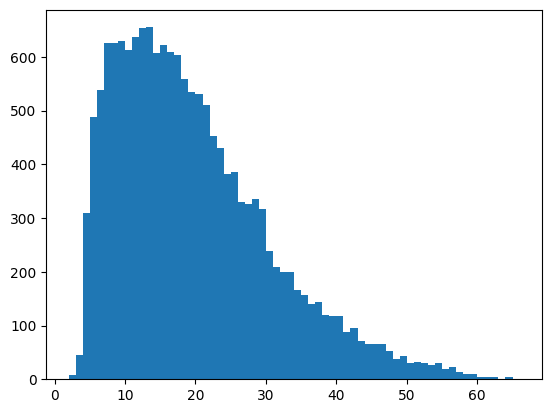

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequence(tokenizer,text):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequence = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequence

In [ ]:
padded_train_seq = get_sequence(tokenizer,tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels
Tweets are labeled by **emotions** (joy, sadness, anger, etc.). We must convert these labels into **numbers** so the model can understand them.


1. Map each label (like 'joy') to an integer (like 0).
2. Convert text labels to numeric labels.

In [ ]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'anger', 'love', 'fear', 'sadness'}


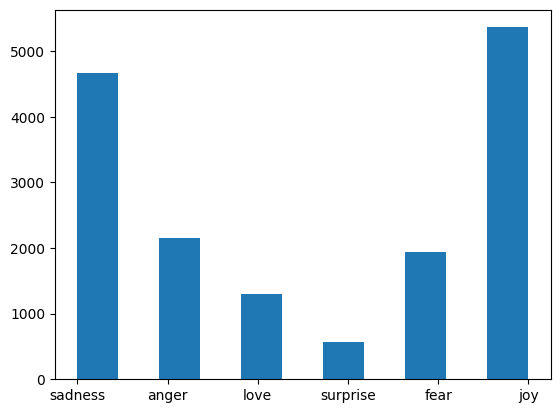

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'surprise': 0, 'joy': 1, 'anger': 2, 'love': 3, 'fear': 4, 'sadness': 5}

In [ ]:
index_to_class

{0: 'surprise', 1: 'joy', 2: 'anger', 3: 'love', 4: 'fear', 5: 'sadness'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## Task 7: Creating the Model
Now we build our deep learning model. It will:


1. Use an **Embedding layer** to convert words into vectors.
2. Use **Bidirectional LSTMs** to capture word meaning and context.
3. Use a **Dense layer** with softmax activation to output probabilities for each emotion.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.build(input_shape=(None, maxlen))


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model
We now train the model using training data, and validate on the validation set.


1. Convert validation tweets into sequences.
2. Train the model for up to 20 epochs (but stop early if validation accuracy stops improving).

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequence(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(5))

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.7198 - loss: 0.7365 - val_accuracy: 0.7685 - val_loss: 0.6586
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.8296 - loss: 0.4789 - val_accuracy: 0.8350 - val_loss: 0.5200
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.9011 - loss: 0.3052 - val_accuracy: 0.8635 - val_loss: 0.4503
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.9363 - loss: 0.2086 - val_accuracy: 0.8705 - val_loss: 0.4363
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9516 - loss: 0.1565 - val_accuracy: 0.8695 - val_loss: 0.5119
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9509 - loss: 0.1562 - val_accuracy: 0.8960 - val_loss: 0.3822
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.9762 - loss: 0.0845 - val_accuracy: 0.8870 - val_loss: 0.4177
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9801 - loss: 0.0650 - 

## Task 9: Evaluating the Model
Finally, we check how good our model is.


Steps:
1. Plot training history (accuracy & loss).
2. Evaluate on the test set.
3. Look at individual predictions.
4. Show a **confusion matrix** to see where the model is making mistakes.

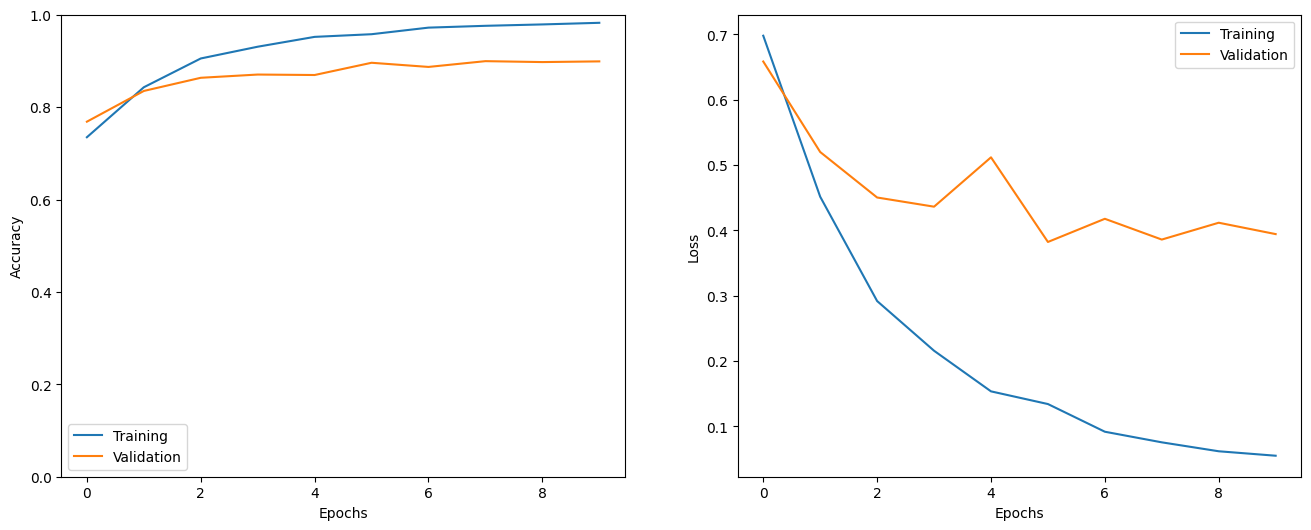

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequence(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8842 - loss: 0.4465


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i found myself feeling a bit overwhelmed
Emotion: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Emotion: surprise


In [ ]:
preds = np.argmax(model.predict(test_seq), axis=-1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


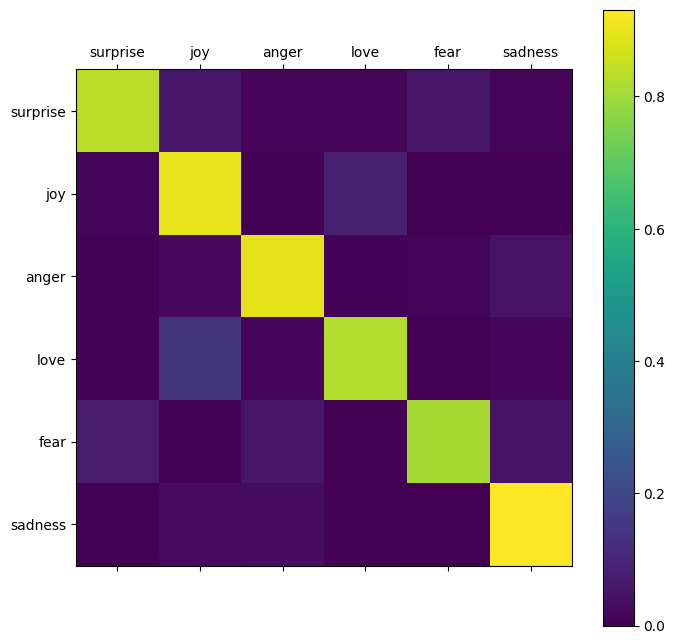

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))